In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog 
from numpy.linalg import solve
import urllib.request
import os
import day_ahead
import pulp as plp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Downloading and parsing data for Consumption Prognosis

In [5]:
if not os.path.exists('data'):
    os.makedirs('data')

#Consumption prognosis data source on Nord Pool's website
url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/consumption-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url, 'data/consumption.xls');

#Convert de .xls file into a Data Frame
consumptionProg_raw_data = pd.read_html('data/consumption.xls')[0].values
consumptionProg_df = pd.DataFrame(consumptionProg_raw_data)
consumptionProg_df.columns = ['Dates', 'Hours', 'NO', 'SE', 'FI', 'DK1', 'DK2', 'EE', 'LV', 'LT']
consumptionProg_df = consumptionProg_df[['Dates', 'Hours', 'DK1', 'DK2']]
consumptionProg_df['Hours'] = consumptionProg_df['Hours'].str.slice(stop=2)
consumptionProg_df['ts'] = pd.to_datetime(consumptionProg_df['Dates'] + consumptionProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
consumptionProg_df = consumptionProg_df[consumptionProg_df['ts'] < pd.to_datetime('2019-02-01')]

## Including Import of DK1 <- Norway (200MW)
consumptionProg_df['DK1'] = consumptionProg_df['DK1'] - 200

## Including Export of DK1 -> Germany (100MW)
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('07:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('14:00:00').time()):
        consumptionProg_df['DK1'][i] = consumptionProg_df['DK1'][i] + 100
        
## Including Import of DK2 <- Sweden (150MW)
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('13:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('19:00:00').time()):
        consumptionProg_df['DK2'][i] = consumptionProg_df['DK2'][i] - 150

c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Downloading and parsing data for Wind Power Generation Prognosis

In [6]:
#Wind power generation prognosis data source on Nord Pool's website
url2 = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url2, 'data/wind-prognosis.xls');

#Convert de .xls file into a Data Frame
windProg_raw_data = pd.read_html('data/wind-prognosis.xls')[0].values
windProg_df = pd.DataFrame(windProg_raw_data)
windProg_df.columns = ['Dates', 'Hours', 'DK1', 'DK2']
windProg_df['Hours'] = windProg_df['Hours'].str.slice(stop=2)
windProg_df['ts'] = pd.to_datetime(windProg_df['Dates'] + windProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
windProg_df = windProg_df[windProg_df['ts'] < pd.to_datetime('2019-02-01')]

#Set the proportion of wind power generation to each producer in each region
windProg_df['WW1'] = windProg_df['DK1']*(1/4)
windProg_df['WW2'] = windProg_df['DK1']*(3/4)
windProg_df['EW1'] = windProg_df['DK2']*(1/3)
windProg_df['EW2'] = windProg_df['DK2']*(2/3)
#Remove unwanted columns from Dataframe
windProg_df = windProg_df.drop(['Dates', 'Hours', 'DK1', 'DK2'], axis=1)

In [7]:
#List of all energy suppliers by region with their respective offers (energy quantity and bid price)
region_g = ['DK1', 'DK1', 'DK2', 'DK2', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1','DK1', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2']
cost_g = np.array([0, -17, -20, -12, 70, 64, 153, 82, 89, 25, 250, 19, 43, 39, 36, 31, 5, 10, 250])
power_g_all = np.array([400, 330, 345, 390, 510, 1000, 900, 1200, 320, 360, 400, 350, 730, 630, 800])
#Array considering time restriction of some generators
power_g_rest = np.array([400, 330, 345, 390, 510, 0, 900, 0, 320, 360, 400, 350, 730, 630, 800])

generationProg_df = windProg_df

#Include the supplier energy offers into the generation dataframe according to their time of operation
for i in range(15):
    generationProg_df['G{}'.format(i+1)] = power_g_rest[i]
    
for i in generationProg_df.index:
    if (generationProg_df['ts'][i].time() >= pd.to_datetime('05:00:00').time()) & (generationProg_df['ts'][i].time() < pd.to_datetime('22:00:00').time()):
        generationProg_df['G6'][i] = power_g_all[5]
        generationProg_df['G8'][i] = power_g_all[7]

c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
#Solve the optimization problem for every time slot of the day-ahead market using the demand and supply offers
#A function named 'day_ahead.solver' was created to solve the linear programming optimization problem
    #INPUT: generation (DF), demand (DF) and interconnection limitaiton.
    #OUTPU: scheduled generation (DF), scheduled demand (DF) and amount of interconnection used
schedule_g = {}
schedule_d = {}
price = {}

limit = 600

#Arrange the data from generation and consumption prognosis into dataframes in the correct structure to be utilized by the function
for i in range(len(consumptionProg_df)):
    g_df = pd.DataFrame({'ID' : list(generationProg_df)[1:],
                         'region' : region_g,
                         'power_g' : generationProg_df[list(generationProg_df)[1:]].values[i],
                         'cost_g' : cost_g})

    d_df = pd.DataFrame({'ID' : ['D1','D2'],
                         'region' : list(consumptionProg_df)[2:-1],
                         'power_d' : consumptionProg_df[list(consumptionProg_df)[2:-1]].values[i],
                         'cost_d' : [99999, 99999]})
    
    schedule_g[consumptionProg_df['ts'][i]], schedule_d[consumptionProg_df['ts'][i]], price[consumptionProg_df['ts'][i]] = day_ahead.solver(g_df, d_df, limit)
 


## Adjusting market price for wind farms with support schemes

In [11]:
#Add the respective support scheme for each wind power generation to calculate their revenues
for key in schedule_g.keys():
    schedule_g[key]['Market Price'][1] = price[key]['DK1'] + 17
    schedule_g[key]['Market Price'][9] = 20
    schedule_g[key]['Market Price'][10] = price[key]['DK2'] + 12
    schedule_g[key]['Revenue'] = schedule_g[key]['Market Price'] * schedule_g[key]['Scheduled Pg']

c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\s190045\pycharmprojects\untitled\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

### Suppliers Dictionary

In [13]:
suppliers_dict = {'WW1' : 'WestWind1',
                 'WW2' : 'WestWind2',
                 'G1' : 'FlexiGas',
                 'G2' : 'FlexiGas',
                 'G3' : 'FlexiGas',
                 'G4' : 'Peako',
                 'G5' : 'Peako',
                 'G6' : 'Nuke22',
                 'G7' : 'CoalAtLast',
                 'EE1' : 'EastWind1',
                 'EE2' : 'EastWind2',
                 'G8' : 'Nuke22',
                 'G9' : 'RoskildeCHP',
                 'G10' : 'RoskildeCHP',
                 'G11' : 'Avedovre',
                 'G12' : 'Avedovre',
                 'G13' : 'BlueWater',
                 'G14' : 'BlueWater',
                 'G15' : 'CoalAtLast'}

## Verifying congestion in the interconnection

In [14]:
#We check the congestion of the interconnection by analyzing the difference of scheduled energy for consumption and demand on DK1
congestion_df = pd.DataFrame()
for key in schedule_d.keys():
    
    DK1_supply = schedule_g[key][schedule_g[key]['Region'] == 'DK1']['Scheduled Pg'].sum()
    DK1_demand = schedule_d[key][schedule_d[key]['Region'] == 'DK1']['Scheduled Pd'].sum()

    energy_exchanged = DK1_supply - DK1_demand

    if abs(energy_exchanged) == limit:
        congestion = 1
    else:
        congestion = 0
    
    congestion_df = congestion_df.append({'ts': key,
                                          'Energy Exchanged' : energy_exchanged,
                                          'Congestion' : congestion}, ignore_index=True)

print('The interconnection was congested in {} timesteps (hours).'.format(congestion_df['Congestion'].sum()))    

print('Which represents aproximetely {} % of the analyzed period.'.format(round(100*congestion_df['Congestion'].sum()/len(congestion_df['Congestion']))))    


The interconnection was congested in 511.0 timesteps (hours).
Which represents aproximetely 69.0 % of the analyzed period.


## Calculating suppliers revenues

In [10]:
#Revenues are calculated considering each the scheduled quantities for each supplier and market price for each time slot
revenue_df = pd.concat([pd.DataFrame(schedule_g[key]['Revenue'].values, columns=[key]) for key in schedule_d.keys()], axis = 1)
revenue_df.index = suppliers_dict.keys()
print('Suppliers Revenues: \n')
print(revenue_df.sum(axis=1))

Suppliers Revenues: 

WW1    5.678087e+06
WW2    3.136378e+07
G1     3.670740e+06
G2     5.534338e+06
G3     0.000000e+00
G4     1.142750e+06
G5     1.982920e+05
G6     1.441250e+07
G7     0.000000e+00
EE1    2.357553e+06
EE2    5.268758e+06
G8     5.894364e+06
G9     0.000000e+00
G10    1.848600e+04
G11    4.615200e+05
G12    1.187862e+06
G13    8.825185e+06
G14    7.218610e+06
G15    0.000000e+00
dtype: float64


## Checking if load shedding happened

In [21]:
#Check amount of load shedding by analyzing if the demand was ever greater than the supply for each region
demand_scheduled = pd.concat([pd.DataFrame([schedule_d[key]['Scheduled Pd'].sum()], columns=[key]) for key in schedule_d.keys()], axis = 1).T

load_shedding = pd.DataFrame({'ts' : consumptionProg_df['ts'],
                              'Total Demand' : consumptionProg_df['DK1'] + consumptionProg_df['DK2'],
                              'Scheduled Demand' : demand_scheduled[0].values})

load_shedding['Difference'] = load_shedding['Total Demand'] - load_shedding['Scheduled Demand']
print('Total load shedding: {} MWh'.format(load_shedding['Difference'].sum()))

Total load shedding: 0.0 MWh


## Checking days with high and low wind penetration

In [22]:
#High wind penetration: Wind power production to meet demand
#Low wind penetration: lowest ration between the wind energy produced by the total consumption of any given time slot
wind_generation = pd.concat([pd.DataFrame([schedule_g[key]['Scheduled Pg'][0] + schedule_g[key]['Scheduled Pg'][1] + schedule_g[key]['Scheduled Pg'][9] + schedule_g[key]['Scheduled Pg'][10]], columns=[key]) for key in schedule_d.keys()], axis = 1).T

WP = pd.DataFrame({'ts' : load_shedding['ts'],
                                 'Demand' : load_shedding['Scheduled Demand'],
                                 'Wind Suply' : wind_generation[0].values})
daily_WP = WP.set_index('ts').resample('D').agg(['sum'])

WP['WP'] = WP['Wind Suply']/WP['Demand']
daily_WP['WP'] = daily_WP['Wind Suply']/daily_WP['Demand']

day_max_WP = daily_WP['WP'].idxmax()
day_min_WP = daily_WP['WP'].idxmin()

daily_WP_max = daily_WP['WP'][day_max_WP]
daily_WP_min = daily_WP['WP'][day_min_WP]

high_day_df = WP.set_index('ts').loc['2019-01-01 00:00:00':'2019-01-01 23:59:59']
low_day_df = WP.set_index('ts').loc['2019-01-20 00:00:00':'2019-01-20 23:59:59']


high_ts = pd.to_datetime('2019-01-01 11:00:00')
low_ts = WP.set_index('ts').loc['2019-01-20 00:00:00':'2019-01-20 23:59:59']['WP'].idxmin()

#Since the consumption was met by the wind power production in different days, one was selected
#HIGH WP: 01/01/2019 at 11:00 AM
#LOW WP: 20/01/2019 at 11:00 AM

## Plotting the prices of high and low Wind Power Penetration days

TypeError: float() argument must be a string or a number, not 'datetime.time'

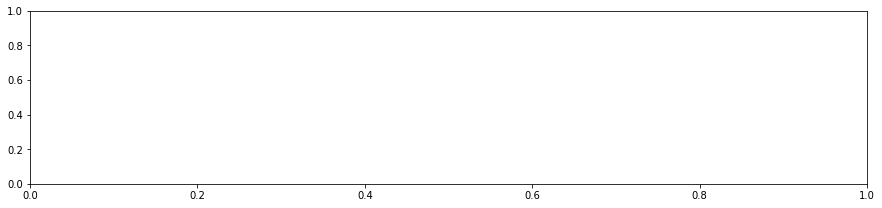

In [28]:
prices_DK1 = pd.concat([pd.DataFrame([schedule_d[key]['Market Price'][0]], columns=[key]) for key in schedule_d.keys()], axis = 1).T
prices_DK2 = pd.concat([pd.DataFrame([schedule_d[key]['Market Price'][1]], columns=[key]) for key in schedule_d.keys()], axis = 1).T

fig = plt.figure(figsize=(15,7))

y1 = prices_DK1.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].values
x1 = prices_DK1.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].index.time

y2 = prices_DK2.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].values
x2 = prices_DK2.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].index.time

y3 = low_day_df.WP.values
x3 = low_day_df.index.time

y4 = high_day_df.WP.values
x4 = high_day_df.index.time

plt.subplot(2,1,1)
plt.plot(x3, y3, color = 'red')
plt.plot(x4, y4, color = 'blue')
plt.ylabel('Wind Power Penetration', fontsize = 'large')
plt.xlim(['00:00:00','23:00:00'])
plt.xticks(x1, rotation = 45)
plt.grid()
plt.legend(['Low WP - 20/Jan', 'High WP - 01/Jan'])

plt.subplot(2,1,2)
plt.plot(x1, y1, color = 'red')
plt.plot(x2, y2, color = 'blue')
plt.ylabel('Price [\u20ac/MWh]', fontsize = 'large')
plt.xlim(['00:00:00','23:00:00'])
plt.xticks(x3, rotation = 45)
plt.grid()
plt.legend(['Low WP - 20/Jan', 'High WP - 01/Jan'])
plt.show()

In [29]:
x3

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0),
       datetime.time(3, 0), datetime.time(4, 0), datetime.time(5, 0),
       datetime.time(6, 0), datetime.time(7, 0), datetime.time(8, 0),
       datetime.time(9, 0), datetime.time(10, 0), datetime.time(11, 0),
       datetime.time(12, 0), datetime.time(13, 0), datetime.time(14, 0),
       datetime.time(15, 0), datetime.time(16, 0), datetime.time(17, 0),
       datetime.time(18, 0), datetime.time(19, 0), datetime.time(20, 0),
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

ImportError: matplotlib is required for plotting.

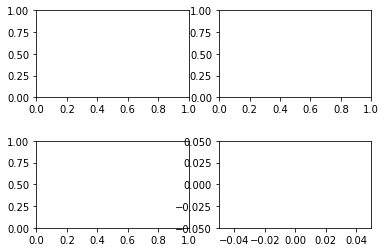

In [27]:
## HIGH PENETRATION DAY

curve_g_df = pd.DataFrame({'Pg' : generationProg_df.set_index('ts').loc[high_ts]})
curve_g_df['Bid'] = cost_g
curve_g_df['Zone'] = region_g
curve_g_DK1_df = curve_g_df.loc[curve_g_df.Zone=='DK1'].sort_values(by='Bid')
curve_g_DK2_df = curve_g_df.loc[curve_g_df.Zone=='DK2'].sort_values(by='Bid')
curve_g_DK1_df['Supply'] = curve_g_DK1_df['Pg'].cumsum()
curve_g_DK2_df['Supply'] = curve_g_DK2_df['Pg'].cumsum()
curve_g_DK1_df = curve_g_DK1_df.drop(['Zone', 'Pg'], axis=1).set_index('Supply')
curve_g_DK2_df = curve_g_DK2_df.drop(['Zone', 'Pg'], axis=1).set_index('Supply')

fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace = 0.5)
plt.autoscale(tight=True)

curve_g_DK1_df.plot(drawstyle="steps-post",linewidth=2, figsize = (15,5), ax=axes[0,0])
axes[0,0].axvline(consumptionProg_df.set_index('ts').loc[high_ts]['DK1'], color = 'red')
axes[0,0].set_ylabel('Bid [\u20ac/MWh]')
axes[0,0].set_xlabel('')
axes[0,0].legend(['Supply','Demand'])
axes[0,0].set_xlabel('Quantity [MWh]')
axes[0,0].set_title('DK1 - High Wind Power Penetration Day')
axes[0,0].set_xlim([0,7000])


curve_g_DK2_df.plot(drawstyle="steps-post",linewidth=2, ax=axes[0,1])
axes[0,1].axvline(consumptionProg_df.set_index('ts').loc[high_ts]['DK2'], color = 'red')
axes[0,1].set_ylabel('Bid [\u20ac/MWh]')
axes[0,1].set_xlabel('')
axes[0,1].legend(['Supply','Demand'])
axes[0,1].set_xlabel('Quantity [MWh]')
axes[0,1].set_title('DK2 - High Wind Power Penetration Day')
axes[0,1].set_xlim([0,6000])


## LOW PENETRATION DAY

curve_g_df = pd.DataFrame({'Pg' : generationProg_df.set_index('ts').loc[low_ts]})
curve_g_df['Bid'] = cost_g
curve_g_df['Zone'] = region_g
curve_g_DK1_df = curve_g_df.loc[curve_g_df.Zone=='DK1'].sort_values(by='Bid')
curve_g_DK2_df = curve_g_df.loc[curve_g_df.Zone=='DK2'].sort_values(by='Bid')
curve_g_DK1_df['Supply'] = curve_g_DK1_df['Pg'].cumsum()
curve_g_DK2_df['Supply'] = curve_g_DK2_df['Pg'].cumsum()
curve_g_DK1_df = curve_g_DK1_df.drop(['Zone', 'Pg'], axis=1).set_index('Supply')
curve_g_DK2_df = curve_g_DK2_df.drop(['Zone', 'Pg'], axis=1).set_index('Supply')


curve_g_DK1_df.plot(drawstyle="steps-post",linewidth=2, figsize = (15,5), ax=axes[1,0])
axes[1,0].axvline(consumptionProg_df.set_index('ts').loc[low_ts]['DK1'], color = 'red')
axes[1,0].set_ylabel('Bid [\u20ac/MWh]')
axes[1,0].set_xlabel('Quantity [MWh]')
axes[1,0].legend(['Supply','Demand'])
axes[1,0].set_title('DK1 - Low Wind Power Penetration Day')
axes[1,0].set_xlim([0,4200])

curve_g_DK2_df.plot(drawstyle="steps-post",linewidth=2, ax=axes[1,1])
axes[1,1].axvline(consumptionProg_df.set_index('ts').loc[low_ts]['DK2'], color = 'red')
axes[1,1].set_ylabel('Bid [\u20ac/MWh]')
axes[1,1].set_xlabel('Quantity [MWh]')
axes[1,1].legend(['Supply','Demand'])
axes[1,1].set_title('DK2 - Low Wind Power Penetration Day')
axes[1,1].set_xlim([0,5000])

In [47]:
windProg_df.set_index('ts').loc[high_ts]['DK1']

2957